# Notes
Added a preconverted jpg data library to kernel from https://www.kaggle.com/vaillant/discussion see explanation for RGB channels<BR>
Starter code from https://www.kaggle.com/orkatz2/pulmonary-embolism-pytorch-train

In [21]:
# import sys
# print(sys.path)
# print(sys.executable)
# # !echo $PATH
# # !pip install pidicom
# # !conda install -c conda-forge pydicom -y
# !conda list


# sys.path.append('/lib/python3.7/site-packages')
# from PIL import Image

#its a bit hard to install pillow-SIMD
# !conda update --all -y
# !conda list
# !pip install Pillow-SIMD -y
# !conda uninstall pillow -y
#!conda install pydicom -y
# !conda install matplotlib

In [22]:


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
import functools
import glob


import gc
from PIL import Image
import torchvision.transforms as transforms
import pydicom

In [23]:
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

# Create Dataset

In [24]:
#where the data is
PATH = '../input/rsna-str-pulmonary-embolism-detection'
PATH_TEST=PATH+'/test/'

In [25]:
from PIL import Image

# For validation images
transforms_val = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
])

class CTDatasetDicom(Dataset):
    def __init__(self,df,path,transforms=None,preprocess_to_train_format=None,size=254,mode='val'):
        
        #get a numpy representation of the pandas dataframe
        self.df = df.values   
        self.path = path
        self.transforms = transforms
#         self.preprocessing = preprocessing
        self.preprocess_to_train_format = preprocess_to_train_format
        self.size=size


    #window just like we did on training set
    def _window(self,img, WL=50, WW=350):
        upper, lower = WL+WW//2, WL-WW//2
        X = np.clip(img.copy(), lower, upper)
        X = X - np.min(X)
        X = X / np.max(X)
        X = (X*255.0).astype('uint8')
        return X

    def __getitem__(self, idx):
        row = self.df[idx] 
#         print(row)
          
        #get the dicom data, preprocess it to the same format that we used in training
        dcm_data = pydicom.dcmread(f"{self.path}/{row[0]}/{row[1]}/{row[2]}.dcm")
        image = dcm_data.pixel_array * int(dcm_data.RescaleSlope) + int(dcm_data.RescaleIntercept)
        image = np.stack([self._window(image, WL=-600, WW=1500),
                          self._window(image, WL=40, WW=400),
                          self._window(image, WL=100, WW=700)], 2)
        
#         if self.preprocessing:
#             image = self.preprocessing(image)
 
        if self.transforms:
            image = self.transforms(image)
            
        #return study id and imageid
        return row[0],row[2],image

    def __len__(self):
        return len(self.df)
    
    #this function gets a balanced set, 1/2 have pe_present_on_image=1, 1/2 have pe_present_on_image=0
    #note that we discard a bunch of images that have no pe present
#     def generate_balanced_set(self):
#         df0 = self.df_main[self.df_main[:,3]==0]
#         df1 = self.df_main[self.df_main[:,3]==1]
#         np.random.shuffle(df0)
#         self.df = np.concatenate([df0[:len(df1)],df1],axis=0)
        

# def norm(img):
#     img-=img.min()
#     return img/img.max()

## Create dataframe

In [26]:
test_df = pd.read_csv("../input/rsna-str-pulmonary-embolism-detection/test.csv",dtype={'StudyInstanceUID':'string', 'SeriesInstanceUID':'string', 'SOPInstanceUID':'string'})
# test_df = test_df.set_index('SOPInstanceUID')
listOfStudyID = test_df['StudyInstanceUID'].unique()
print(len(listOfStudyID))
print(len(test_df))

# test_df.head()
# test_df.describe()
# test_df.count()

650
146853


## Create CTDatasetDicom from Dataframe

In [27]:
test_dataset = CTDatasetDicom(test_df,path= PATH_TEST, transforms=transforms_val)

In [28]:
# #visualize stuff
# print(len(test_dataset))
# img = test_dataset[0]
# img.shape
# img

## Create Dataframe to track StudyInstanceUID parameters

For every series (SeriesInstanceUID) make predictions for every image in that series.  Create a dataframe consisting of 1 row per series.  Each row has 10 columns, the series value and the following 9 columns.

Then use the model to predict all of those 9 values for each image (SOPInstanceUID) in the series. Save the largest image prediction for each column out of all the image in the series 

Presto have largest prediction per series

In [29]:
# #dataframe tutorial
# cols=['series1','b','c']
# series=['1a','2a','3a','4a','5a']
# df=pd.DataFrame(columns=cols)

# df.head()
# for i,val in enumerate(series):
#     df.loc[i,'series1'] = val

# df.head()

# df.loc[df['series1']== '1a','b']=2
# #  thisStudyDF = test_df[test_df['StudyInstanceUID']==eachStudyID]

## Create dataloader from CTDatasetDicom

In [30]:
from snippets import config

In [31]:
test_dl = DataLoader(test_df, batch_size=config.batch_size*2, shuffle=False, num_workers=config.WORKERS, pin_memory=True)

In [32]:
listOfStudyID[0]
thisStudyDF = test_df[test_df['StudyInstanceUID']==listOfStudyID[0]]
len(thisStudyDF)
# thisStudyDF

144

In [33]:
# eachImageID=thisStudyDF.index[0]
# import pydicom

# # eachImagePath = '../input/rsna-str-pulmonary-embolism-detection/test/'+test_df.loc[eachImageID, 'StudyInstanceUID']+'/'+test_df.loc[eachImageID, 'SeriesInstanceUID']+'/'+eachImageID+'.dcm'
# eachImagePath = '../input/rsna-str-pulmonary-embolism-detection/test/00268ff88746/75d23269adbd/012c12fe09c3.dcm'
# dcm_data = pydicom.dcmread(eachImagePath)
# image = dcm_data.pixel_array * int(dcm_data.RescaleSlope) + int(dcm_data.RescaleIntercept)
# image = np.stack([test_dataset._window(image, WL=-600, WW=1500),
#                   test_dataset._window(image, WL=40, WW=400),
#                   test_dataset._window(image, WL=100, WW=700)], 2)

# print(image.shape)
# # image = image.astype(np.float32)
# image = preprocessing_val(image)
# toPred = image.unsqueeze(0)
# print(image.shape)
# # z = model(toPred)
# # pred = torch.sigmoid(z)
# # pred1 = pred.detach().numpy().astype('float32')[0]

# Load Model

In [34]:
#where should it go
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [35]:

# Load the model that was just trained
#and do following inference with it
model = models.resnet18(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features,config.numb_classes)

#it was saved on GPU, load it on CPU
model.load_state_dict(torch.load(config.MODEL_PARAMS_LOC, map_location=torch.device('cpu')))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
%load_ext autoreload
%autoreload 2
# import importlib
# importlib.reload(snippets)
config.numb_classes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


14

# Prediction generator

Goes in another notebook

In [37]:
exam_level_features = ['negative_exam_for_pe', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',
                       'leftsided_pe',         'chronic_pe',        'rightsided_pe', 
                       'acute_and_chronic_pe', 'central_pe',        'indeterminate']

#create columns
index = ['StudyInstanceUID']

all = (index)
all.extend(exam_level_features)

#create dict of unique StudyInstanceUID
studies={'StudyInstanceUID':listOfStudyID}

totals_per_series = pd.DataFrame(studies,columns=all).fillna(0.0)

In [38]:
# %time
# from snippets import SInstUID_tracker

# import time
# start_time = time.perf_counter()
 
# f = open('submission.csv', 'w')
# f.write('id,label\n')

# sidt = SInstUID_tracker(test_df )
# imgs_processed=0

# # dev = 'cpu'
# model.to(dev)
# with torch.no_grad():

#     for eachStudyID in tqdm(listOfStudyID):
        
#         #get one study
#         thisStudyDF = test_df[test_df['StudyInstanceUID']==eachStudyID]
        
#         #create a dataset from that study
#         test_dataset = CTDatasetDicom(thisStudyDF,path= PATH_TEST, transforms=transforms_val)
        
#         #create a dataloader for just that study
#         test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=config.WORKERS, pin_memory=True)        
# #         test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size*4, shuffle=False, num_workers=config.WORKERS, pin_memory=True)
# #         tqdm_loader = tqdm(test_dataloader)
#         for idx, images in enumerate(test_dataloader):
#             images=images.to(dev)
# #             print(len(images))
            
#             pred=model(images)
#             pred = torch.sigmoid(pred)
            
#             print(pred)
#             raise
            
#             imgs_processed+=64
#             if(imgs_processed>1000):
#                 elapsed_time = time.perf_counter() - start_time
#                 tpall =((elapsed_time/1000.0)*1500000)/60.0
#                 print(f'time to do 1.5 million images {tpall:0.4f} minutes')
                #its 574 minutes for CPU
                #its 111 minutes with bathcsize of 64 on GPU
                #with only 1 data_loader for the whole set its 90 minutes
#             print(pred)
#             raise
            
            
            
#         for eachImageID in thisStudyDF.index:
            
# #             try:
#                 eachImagePath = '../input/rsna-str-pulmonary-embolism-detection/test/'+test_df.loc[eachImageID, 'StudyInstanceUID']+'/'+test_df.loc[eachImageID, 'SeriesInstanceUID']+'/'+eachImageID+'.dcm'
#                 dcm_data = dcmread(eachImagePath)
#                 image = dcm_data.pixel_array * int(dcm_data.RescaleSlope) + int(dcm_data.RescaleIntercept)
#                 image = np.stack([window(image, WL=-600, WW=1500),
#                                   window(image, WL=40, WW=400),
#                                   window(image, WL=100, WW=700)], 2)

#                 image = image.astype(np.float32)
#                 image = data_transform(image)
#                 toPred = image.unsqueeze(0).cuda()
#                 z = model(toPred)
#                 pred = torch.sigmoid(z)
#                 pred = pred.cpu().detach().numpy().astype('float32')[0,0]

#             except:
#                 pred = defaultScore['_pe_present_on_image']
          

In [39]:
df_image_results=pd.DataFrame( columns=['image','pe_present_on_image' ])
df_image_results=df_image_results.append({'image':'1 image', 'pe_present_on_image':5.0}, ignore_index=True)
df_image_results=df_image_results.append({'image':'2 image', 'pe_present_on_image':5.0}, ignore_index=True)
df_image_results=df_image_results.append({'image':'3 image', 'pe_present_on_image':5.0}, ignore_index=True)

df_image_results.head()

,image,pe_present_on_image
0,1 image,5.0
1,2 image,5.0
2,3 image,5.0


In [ ]:
%time

from snippets import SInstUID_tracker
import time
start_time = time.perf_counter()
 
imgs_processed=0
df_image_results=pd.DataFrame( columns=['image','pe_present_on_image' ])

# dev = 'cpu'
model.to(dev)
with torch.no_grad():
       
    sidt = SInstUID_tracker(test_df )
    
    #create a dataset from that study
    test_dataset = CTDatasetDicom(test_df,path= PATH_TEST, transforms=transforms_val)

    #create a dataloader for just that study
    test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=config.WORKERS, pin_memory=True)        

    start_time = time.perf_counter()
    for idx, (studyids,imageSOP,images) in enumerate(test_dataloader):
        images=images.to(dev)

        preds=model(images)
        preds=torch.sigmoid(preds).cpu()
 
        # memory leak is in here and it increases time by 1.5
        for i,pred in enumerate(preds):
            pred=pred.numpy()
            #the following increases from 88 to 105 mins
            sidt.record(studyids[i],pred)
        #the following line greatly increases time to run from 88 to 104 minutes and it leaks
#             df_image_results=df_image_results.append({'image':images[i], 'pe_present_on_image':preds[0]}, ignore_index=True)

        del images,studyids,imageSOP
        
        imgs_processed+=256
        if(imgs_processed>10000):
            elapsed_time = time.perf_counter() - start_time
            tpall =((elapsed_time/10000.0)*1500000)/60.0
            if (np==NONE):
                np=1
                print(f'time to do 1.5 million images {tpall:0.4f} minutes')

CPU times: user 22 µs, sys: 1 µs, total: 23 µs
Wall time: 6.2 µs
time to do 1.5 million images 105.7608 minutes
time to do 1.5 million images 107.9897 minutes
time to do 1.5 million images 110.1135 minutes
time to do 1.5 million images 112.3553 minutes
time to do 1.5 million images 114.6497 minutes
time to do 1.5 million images 116.8905 minutes
time to do 1.5 million images 119.2851 minutes
time to do 1.5 million images 121.6337 minutes
time to do 1.5 million images 124.1165 minutes
time to do 1.5 million images 126.2823 minutes
time to do 1.5 million images 128.4726 minutes
time to do 1.5 million images 130.7151 minutes
time to do 1.5 million images 132.9251 minutes
time to do 1.5 million images 135.5015 minutes
time to do 1.5 million images 138.0049 minutes
time to do 1.5 million images 140.6285 minutes
time to do 1.5 million images 142.8150 minutes
time to do 1.5 million images 145.4818 minutes
time to do 1.5 million images 147.7127 minutes
time to do 1.5 million images 149.9113 min

In [ ]:
f = open('submission.csv', 'w')
f.write('id,label\n')


# Junk

In [ ]:
# for img, lbl in train_dl:
#     print(img[0].shape)
#     print(len(lbl[0]))
#     break
# # tmp=next((train_dl))

# import matplotlib.pyplot as plt
# row = train_dataset.df[0]
# print(f"{jpeg_dir}/{row[0]}/{row[1]}/*{row[2]}.jpg")
# img = cv2.imread(glob.glob(f"{jpeg_dir}/{row[0]}/{row[1]}/*{row[2]}.jpg")[0])
# plt.imshow(img)#discard

#how many?
# tot_instances=0

# studies=(os.listdir(PATH_TRAIN))
# studies=sorted(studies)
# print("tot_studies= "+str(len(studies)))

# tot_series=0
# for study in studies:
#     pth=os.path.join(PATH_TRAIN,study)
# #     print(pth)
#     series=os.listdir(pth)
#     tot_series+=len(series)
#     for serie in series:
#         tot_instances+=len(os.listdir(os.path.join(pth,serie)))
# print("tot_series= "+str(tot_series))
# print("tot_instances= "+str(tot_instances))


# class RsnaDataset(Dataset):
    
#     def __init__(self,df,transforms):
#         super().__init__()
#         self.df = df
#         self.transforms = transforms
    
#     def __getitem__(self,index):      
#         image_path = self.df.image_paths[index]
#         data = self.df[self.df['ImagePath']==image_path]
#         labels = data[target_columns].values.reshape(-1)
#         image = get_img(image_path)
#         image = convert_to_rgb(image)
        
#         if self.transforms:
#             image = self.transforms(image=image)['image']
            
#         image = torch.tensor(image,dtype=torch.float)        
#         labels = torch.tensor(labels,dtype=torch.float)
        
#         return image,labels
           
#     def __len__(self):
#         return self.image_paths.shape[0]

In [6]:
#see what above class does
# t_df.head()
# df_tmp=t_df.values
# df_tmp.shape

# df0 = df_tmp[df_tmp[:,3]==0]
# df1 = df_tmp[df_tmp[:,3]==1]
# print(len(df0))
# print(len(df1))

# df_tmp_balanced = np.concatenate([df0[:len(df1)],df1],axis=0)
# print(len(df_tmp_balanced))
# print(sum(df_tmp_balanced[:,3]==0))
# print(sum(df_tmp_balanced[:,3]==1))
# # df0 = self.df_main[self.df_main[:,3]==0]
# #         df1 = self.df_main[self.df_main[:,3]==1]
# #         np.random.shuffle(df0)
# #         self.df = np.concatenate([df0[:len(df1)],df1],axis=0)

In [ ]:
# def get_training_augmentation(y=256,x=256):
# #     train_transform = [albu.RandomBrightnessContrast(p=0.3),
# #                            albu.VerticalFlip(p=0.5),
# #                            albu.HorizontalFlip(p=0.5),
# #                            albu.Downscale(p=1.0,scale_min=0.35,scale_max=0.75,),
# #                            albu.Resize(y, x)]
#     train_transform = [albu.RandomBrightnessContrast(p=0.3),
#                            albu.HorizontalFlip(p=0.5),
#                            albu.Resize(y, x)]
#     return albu.Compose(train_transform)

# def get_validation_augmentation(y=256,x=256):
#     """Add paddings to make image shape divisible by 32"""
#     test_transform = [albu.Resize(y, x)]
#     return albu.Compose(test_transform)

# formatted_settings = {
#             'input_size': [3, 224, 224],
#             'input_range': [0, 1],
#             'mean': [0.485, 0.456, 0.406],
#             'std': [0.229, 0.224, 0.225],}

# def preprocess_to_train_format(dcm_data):
#     '''
#     preprocess the image (numpy array, into same format as the data used to train the model
#     x: input image
#     '''
#     img = dcm_data.pixel_array * int(dcm_data.RescaleSlope) + int(dcm_data.RescaleIntercept)
#     img = np.stack([window(img, WL=-600, WW=1500),
#                       window(img, WL=40, WW=400),
#                       window(img, WL=100, WW=700)], 2)

#     img = image.astype(np.float32)
#     return img


# def preprocess_input(x, mean=None, std=None, input_space="RGB", input_range=None, **kwargs):
 
#     #flips from BGR to RGB (or vice versa I'm not sure)
#     if input_space == "BGR":
#         x = x[..., ::-1].copy()
#         gc.collect()

#     if input_range is not None:
#         if x.max() > 1 and input_range[1] == 1:
#             x = x / 255.0

#     return x


Automatically created module for IPython interactive environment
Image size.......: 512 x 512, 524288 bytes
Pixel spacing....: [0.802734, 0.802734]
Slice location...: (missing)


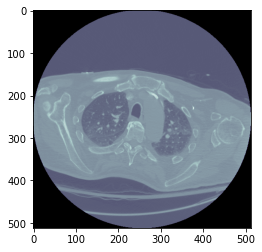

In [56]:
import matplotlib.pyplot as plt
import pydicom
from pydicom.data import get_testdata_files

print(__doc__)

file_path = '../input/rsna-str-pulmonary-embolism-detection/test/00268ff88746/75d23269adbd/012c12fe09c3.dcm'
dataset = pydicom.dcmread(file_path)


if 'PixelData' in dataset:
    rows = int(dataset.Rows)
    cols = int(dataset.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(dataset.PixelData)))
    if 'PixelSpacing' in dataset:
        print("Pixel spacing....:", dataset.PixelSpacing)

# use .get() if not sure the item exists, and want a default value if missing
print("Slice location...:", dataset.get('SliceLocation', "(missing)"))

# plot the image using matplotlib
plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()